In [33]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [78]:
DATASET_PATH = "../easy-dataset.h5"
INTRINSICS = {"focalLength": 1.0, "width": 420.0, "height": 360.0, "zRange": [0.01, 2.0]}

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:3


In [79]:
def move_to_device(batch: tuple[torch.Tensor, ...]):
    return tuple(item.to(device, non_blocking=True) for item in batch)

In [36]:
class EasyDataset(Dataset):
    def __init__(self):
        self._h5_file = None

        with h5py.File(DATASET_PATH, "r") as f:
            self.keys = list(f.keys())
            self.primitives = list(f.attrs["primitives"])

    def _init_h5(self):
        if self._h5_file is None:
            self._h5_file = h5py.File(DATASET_PATH, "r")

    def close(self):
        if self._h5_file is not None:
            self._h5_file.close()
            self._h5_file = None

    def __del__(self):
        self.close()

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        self._init_h5()
        dp = self._h5_file[self.keys[idx]]
        return (dp["depths"][()], dp["masks"][()], dp["goal_maps"][()], dp["quat"][()], dp["feasibles"][()])

In [37]:
dataset = EasyDataset()
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
primitives = dataset.primitives
num_primitives = len(primitives)
print(len(dataset))

5943


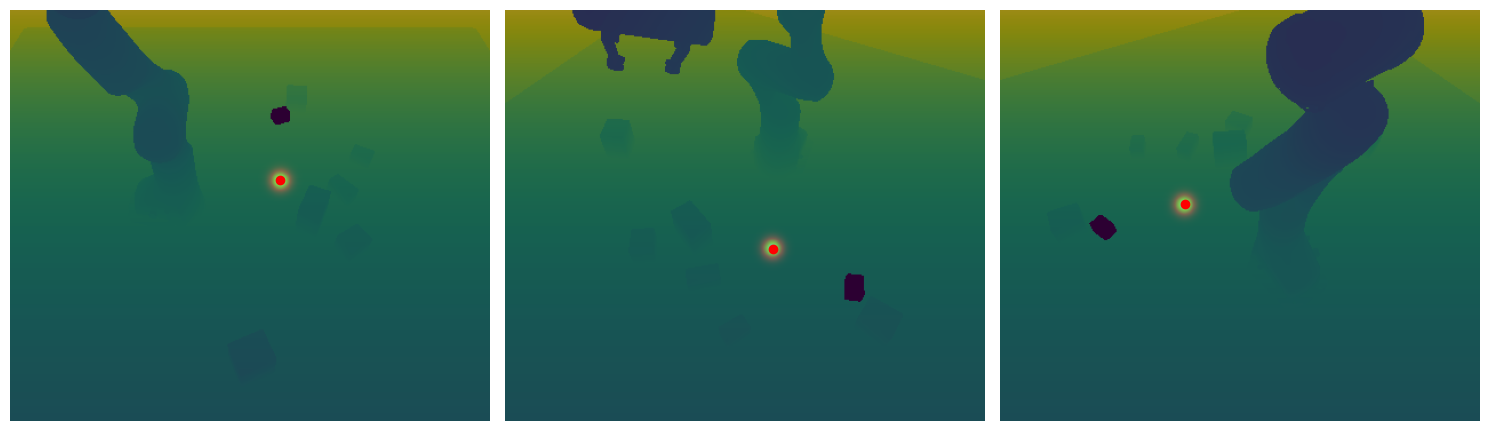

In [38]:
depths, masks, goals, _, _ = dataset[0]
num_views = depths.shape[0]

_, axes2 = plt.subplots(1, num_views, figsize=(5 * num_views, 5), squeeze=False)
for vi in range(num_views):
    depth = depths[vi]
    depth[masks[vi] == 1.0] = 0.0
    goal = goals[vi]
    target_v, target_u = np.unravel_index(np.argmax(goal), goal.shape)

    ax = axes2[0, vi]
    ax.imshow(depth, cmap="viridis")
    ax.imshow(goal, cmap="hot", alpha=0.4)
    ax.scatter([target_u], [target_v], color="red")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [61]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3, stride: int = 1, padding: int = 1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))


class MLPBlock(nn.Module):
    def __init__(self, in_features: int, out_features: int, dropout: float = 0.2):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout(self.relu(self.linear(x)))


class EasyNet(nn.Module):
    def __init__(self, num_views: int, num_primitives: int):
        super().__init__()
        self.num_views = num_views

        in_channels = 3  # depth, mask, goal
        self.feature_extractor = nn.Sequential(
            ConvBlock(in_channels, 32, stride=2),
            ConvBlock(32, 64, stride=1),
            ConvBlock(64, 64, stride=2),
            ConvBlock(64, 128, stride=1),
            ConvBlock(128, 128, stride=2),
            ConvBlock(128, 256, stride=1),
        )

        self.spatial_pool = nn.AdaptiveAvgPool2d((7, 6))

        self.fusion_conv = nn.Sequential(
            ConvBlock(256 * num_views, 512),
            ConvBlock(512, 256),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
        )

        self.quat_encoder = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 64),
            nn.ReLU(inplace=True),
        )

        self.mlp = nn.Sequential(
            MLPBlock(256 + 64, 512),
            MLPBlock(512, 512),
            MLPBlock(512, 256),
        )

        self.feasibility_head = nn.Linear(256, num_primitives)

    def forward(self, depths, masks, goals, quat):
        per_view_features = []
        for v in range(self.num_views):
            x = torch.stack([depths[:, v], masks[:, v], goals[:, v]], dim=1)
            features = self.feature_extractor(x)
            features = self.spatial_pool(features)
            per_view_features.append(features)

        multi_view = torch.cat(per_view_features, dim=1)
        visual_features = self.fusion_conv(multi_view)
        quat_features = self.quat_encoder(quat)

        combined = torch.cat([visual_features, quat_features], dim=1)
        features = self.mlp(combined)

        out = self.feasibility_head(features)
        return out

In [62]:
def compute_feasibility_weights(dataset):
    pos_counts = np.zeros(num_primitives, dtype=np.float32)
    neg_counts = np.zeros(num_primitives, dtype=np.float32)

    for idx in tqdm(range(len(dataset))):
        _, _, _, _, feasibles = dataset[idx]
        pos_counts += feasibles
        neg_counts += 1 - feasibles

    pos_weights = neg_counts / (pos_counts + 1e-8)

    for i, prim in enumerate(dataset.primitives):
        total = pos_counts[i] + neg_counts[i]
        pos_ratio = pos_counts[i] / total
        print(f"{prim:15s}: {pos_ratio:.2%} feasible, pos_weight={pos_weights[i]:.3f}")

    return torch.tensor(pos_weights, dtype=torch.float32)

In [72]:
# pos_weights = compute_feasibility_weights(dataset).to(device)
bce_loss_fn = nn.BCEWithLogitsLoss()

In [73]:
model = EasyNet(num_views=3, num_primitives=num_primitives).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

5857832


In [74]:
train_losses = []
val_losses = []

for epoch in range(5):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        depths, masks, goals, quat, feasibles = move_to_device(batch)
        optimizer.zero_grad()
        logits = model(depths, masks, goals, quat)
        loss = bce_loss_fn(logits, feasibles)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * depths.size(0)
    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            depths, masks, goals, quat, feasibles = move_to_device(batch)
            logits = model(depths, masks, goals, quat)
            loss = bce_loss_fn(logits, feasibles)
            val_loss += loss.item() * depths.size(0)
    val_loss /= len(test_dataset)
    val_losses.append(val_loss)

    # scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]["lr"]
    print(f"epoch {epoch + 1:02d}, train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, lr={current_lr:.2e}")

epoch 01, train_loss=0.5861, val_loss=0.5762, lr=1.00e-02
epoch 02, train_loss=0.5727, val_loss=0.5752, lr=1.00e-02


KeyboardInterrupt: 

In [64]:
def debug_training_step(model, batch, loss_fn, device):
    """Comprehensive debugging for a single training step"""

    depths, masks, goals, quat, feasibles = move_to_device(batch)

    print("=" * 60)
    print("DATA STATISTICS")
    print("=" * 60)
    print(f"Depths - min: {depths.min():.4f}, max: {depths.max():.4f}, mean: {depths.mean():.4f}, std: {depths.std():.4f}")
    print(f"Masks - min: {masks.min():.4f}, max: {masks.max():.4f}, mean: {masks.mean():.4f}, std: {masks.std():.4f}")
    print(f"Goals - min: {goals.min():.4f}, max: {goals.max():.4f}, mean: {goals.mean():.4f}, std: {goals.std():.4f}")
    print(f"Quat - min: {quat.min():.4f}, max: {quat.max():.4f}, mean: {quat.mean():.4f}, std: {quat.std():.4f}")
    print(f"Feasibles - min: {feasibles.min():.4f}, max: {feasibles.max():.4f}, mean: {feasibles.mean():.4f}, std: {feasibles.std():.4f}")
    print(f"Feasibles unique values: {torch.unique(feasibles)}")
    print(f"Positive samples per primitive: {feasibles.sum(dim=0)}")

    print("\n" + "=" * 60)
    print("MODEL PREDICTIONS")
    print("=" * 60)

    model.eval()
    with torch.no_grad():
        logits = model(depths, masks, goals, quat)
        probs = torch.sigmoid(logits)

    print(f"Logits - min: {logits.min():.4f}, max: {logits.max():.4f}, mean: {logits.mean():.4f}, std: {logits.std():.4f}")
    print(f"Probs - min: {probs.min():.4f}, max: {probs.max():.4f}, mean: {probs.mean():.4f}, std: {probs.std():.4f}")
    print(f"First batch logits:\n{logits[0]}")
    print(f"First batch probs:\n{probs[0]}")
    print(f"First batch targets:\n{feasibles[0]}")

    print("\n" + "=" * 60)
    print("GRADIENT FLOW")
    print("=" * 60)

    model.train()
    model.zero_grad()
    logits = model(depths, masks, goals, quat)
    loss = loss_fn(logits, feasibles)
    loss.backward()

    print(f"Loss: {loss.item():.6f}")

    # Check gradients
    total_norm = 0.0
    for name, param in model.named_parameters():
        if param.grad is not None:
            param_norm = param.grad.data.norm(2).item()
            total_norm += param_norm**2
            if "weight" in name or "bias" in name:
                print(f"{name:50s} | grad_norm: {param_norm:.6f} | param_norm: {param.data.norm(2).item():.6f}")

    total_norm = total_norm**0.5
    print(f"\nTotal gradient norm: {total_norm:.6f}")

    # Check for NaN or Inf
    print("\n" + "=" * 60)
    print("NaN/INF CHECK")
    print("=" * 60)
    print(f"Any NaN in logits: {torch.isnan(logits).any()}")
    print(f"Any Inf in logits: {torch.isinf(logits).any()}")
    print(f"Any NaN in gradients: {any(torch.isnan(p.grad).any() for p in model.parameters() if p.grad is not None)}")
    print(f"Any Inf in gradients: {any(torch.isinf(p.grad).any() for p in model.parameters() if p.grad is not None)}")

    return loss.item()

In [69]:
model = EasyNet(num_views=3, num_primitives=num_primitives).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# Get one batch
batch = next(iter(train_loader))
debug_training_step(model, batch, bce_loss_fn, device)

DATA STATISTICS
Depths - min: 0.4650, max: 1.9967, mean: 1.1832, std: 0.3147
Masks - min: 0.0000, max: 1.0000, mean: 0.0035, std: 0.0590
Goals - min: 0.0000, max: 1.0000, mean: 0.0015, std: 0.0274
Quat - min: -0.6744, max: 1.0000, mean: 0.2355, std: 0.4428
Feasibles - min: 0.0000, max: 1.0000, mean: 0.3164, std: 0.4660
Feasibles unique values: tensor([0., 1.], device='cuda:2')
Positive samples per primitive: tensor([ 8.,  5.,  8.,  3., 17., 12., 16., 12.], device='cuda:2')

MODEL PREDICTIONS
Logits - min: -0.0779, max: 0.0237, mean: -0.0223, std: 0.0338
Probs - min: 0.4805, max: 0.5059, mean: 0.4944, std: 0.0084
First batch logits:
tensor([ 0.0221,  0.0026, -0.0423, -0.0778, -0.0162, -0.0470, -0.0404,  0.0223],
       device='cuda:2')
First batch probs:
tensor([0.5055, 0.5007, 0.4894, 0.4806, 0.4960, 0.4882, 0.4899, 0.5056],
       device='cuda:2')
First batch targets:
tensor([0., 0., 1., 0., 1., 0., 1., 0.], device='cuda:2')

GRADIENT FLOW
Loss: 0.981942
feature_extractor.0.conv.weigh

0.9819419980049133

In [70]:
print("=" * 60)
print("BASELINE LOSS ANALYSIS")
print("=" * 60)

batch = next(iter(train_loader))
depths, masks, goals, quat, feasibles = move_to_device(batch)

# Predict all zeros (all negative)
logits_zero = torch.zeros_like(feasibles)
loss_all_neg = bce_loss_fn(logits_zero, feasibles)
print(f"Loss if predicting all negative (logits=0): {loss_all_neg.item():.6f}")

# Predict all ones (all positive)
logits_one = torch.ones_like(feasibles) * 10
loss_all_pos = bce_loss_fn(logits_one, feasibles)
print(f"Loss if predicting all positive (logits=10): {loss_all_pos.item():.6f}")

# Check what the mean feasibility is
mean_feasibility = feasibles.mean(dim=0)
print(f"\nMean feasibility per primitive: {mean_feasibility}")

BASELINE LOSS ANALYSIS
Loss if predicting all negative (logits=0): 0.987570
Loss if predicting all positive (logits=10): 7.421940

Mean feasibility per primitive: tensor([0.1875, 0.1562, 0.3438, 0.1250, 0.2812, 0.4062, 0.2500, 0.3125],
       device='cuda:2')


In [71]:
print("=" * 60)
print("BATCH VARIATION CHECK")
print("=" * 60)

batch1 = next(iter(train_loader))
batch2 = next(iter(train_loader))

d1, m1, g1, q1, f1 = move_to_device(batch1)
d2, m2, g2, q2, f2 = move_to_device(batch2)

print(f"Batch 1 depths mean: {d1.mean():.4f}")
print(f"Batch 2 depths mean: {d2.mean():.4f}")
print(f"Batches are different: {not torch.allclose(d1, d2)}")

BATCH VARIATION CHECK
Batch 1 depths mean: 1.1832
Batch 2 depths mean: 1.1832
Batches are different: True


In [80]:
print("=" * 60)
print("TRAINING WITHOUT POS_WEIGHTS")
print("=" * 60)

model = EasyNet(num_views=3, num_primitives=num_primitives).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Lower LR
bce_loss_simple = nn.BCEWithLogitsLoss()  # No pos_weight

for epoch in range(5):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        depths, masks, goals, quat, feasibles = move_to_device(batch)
        optimizer.zero_grad()
        logits = model(depths, masks, goals, quat)
        loss = bce_loss_simple(logits, feasibles)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * depths.size(0)
    train_loss /= len(train_dataset)

    print(f"epoch {epoch + 1:02d}, train_loss={train_loss:.4f}")

TRAINING WITHOUT POS_WEIGHTS
epoch 01, train_loss=0.5788
epoch 02, train_loss=0.5743
epoch 03, train_loss=0.5733
epoch 04, train_loss=0.5724
epoch 05, train_loss=0.5722


In [81]:
print("\n" + "=" * 60)
print("WEIGHT UPDATE CHECK")
print("=" * 60)

model = EasyNet(num_views=3, num_primitives=num_primitives).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Save initial weights
initial_weights = {name: param.clone() for name, param in model.named_parameters()}

# Train for 1 epoch
for batch in train_loader:
    depths, masks, goals, quat, feasibles = move_to_device(batch)
    optimizer.zero_grad()
    logits = model(depths, masks, goals, quat)
    loss = bce_loss_fn(logits, feasibles)
    loss.backward()
    optimizer.step()

# Check weight changes
print("\nWeight changes after 1 epoch:")
for name, param in model.named_parameters():
    if "weight" in name or "bias" in name:
        diff = (param - initial_weights[name]).abs().mean().item()
        print(f"{name:50s} | mean_abs_change: {diff:.8f}")


WEIGHT UPDATE CHECK

Weight changes after 1 epoch:
feature_extractor.0.conv.weight                    | mean_abs_change: 0.01180071
feature_extractor.0.conv.bias                      | mean_abs_change: 0.00073415
feature_extractor.0.bn.weight                      | mean_abs_change: 0.00750039
feature_extractor.0.bn.bias                        | mean_abs_change: 0.00550061
feature_extractor.1.conv.weight                    | mean_abs_change: 0.00703016
feature_extractor.1.conv.bias                      | mean_abs_change: 0.00009636
feature_extractor.1.bn.weight                      | mean_abs_change: 0.00830172
feature_extractor.1.bn.bias                        | mean_abs_change: 0.00869578
feature_extractor.2.conv.weight                    | mean_abs_change: 0.00715554
feature_extractor.2.conv.bias                      | mean_abs_change: 0.00003960
feature_extractor.2.bn.weight                      | mean_abs_change: 0.00725511
feature_extractor.2.bn.bias                        | mean

In [82]:
print("\n" + "=" * 60)
print("SIMPLER MODEL TEST")
print("=" * 60)


class SimpleNet(nn.Module):
    def __init__(self, num_views: int, num_primitives: int):
        super().__init__()
        self.num_views = num_views

        # Simpler feature extractor
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
        )

        self.mlp = nn.Sequential(
            nn.Linear(64 * num_views + 4, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_primitives),
        )

    def forward(self, depths, masks, goals, quat):
        features = []
        for v in range(self.num_views):
            x = torch.stack([depths[:, v], masks[:, v], goals[:, v]], dim=1)
            feat = self.conv(x)
            features.append(feat)

        visual = torch.cat(features, dim=1)
        combined = torch.cat([visual, quat], dim=1)
        return self.mlp(combined)


simple_model = SimpleNet(num_views=3, num_primitives=num_primitives).to(device)
optimizer = torch.optim.Adam(simple_model.parameters(), lr=1e-4)
bce_loss_simple = nn.BCEWithLogitsLoss()

for epoch in range(10):
    simple_model.train()
    train_loss = 0.0
    for batch in train_loader:
        depths, masks, goals, quat, feasibles = move_to_device(batch)
        optimizer.zero_grad()
        logits = simple_model(depths, masks, goals, quat)
        loss = bce_loss_simple(logits, feasibles)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * depths.size(0)
    train_loss /= len(train_dataset)

    print(f"epoch {epoch + 1:02d}, train_loss={train_loss:.4f}")


SIMPLER MODEL TEST
epoch 01, train_loss=0.6185
epoch 02, train_loss=0.5739
epoch 03, train_loss=0.5730
epoch 04, train_loss=0.5728
epoch 05, train_loss=0.5730
epoch 06, train_loss=0.5730
epoch 07, train_loss=0.5724
epoch 08, train_loss=0.5724
epoch 09, train_loss=0.5726
epoch 10, train_loss=0.5724


In [83]:
print(f"Total dataset size: {len(dataset)}")
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print(f"Batches per epoch: {len(train_loader)}")
print(f"Parameters in original model: {sum(p.numel() for p in model.parameters())}")
print(f"Parameters in simple model: {sum(p.numel() for p in simple_model.parameters())}")

Total dataset size: 5943
Training set size: 4755
Test set size: 1188
Batches per epoch: 149
Parameters in original model: 5857832
Parameters in simple model: 45640


In [84]:
simple_model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        depths, masks, goals, quat, feasibles = move_to_device(batch)
        logits = simple_model(depths, masks, goals, quat)
        probs = torch.sigmoid(logits)
        all_preds.append(probs.cpu())
        all_targets.append(feasibles.cpu())

all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)

print("\n" + "=" * 60)
print("PREDICTION ANALYSIS")
print("=" * 60)

for i, prim in enumerate(primitives):
    preds_for_prim = all_preds[:, i]
    targets_for_prim = all_targets[:, i]
    
    print(f"\n{prim}:")
    print(f"  Target mean: {targets_for_prim.mean():.3f}")
    print(f"  Pred mean: {preds_for_prim.mean():.3f}")
    print(f"  Pred std: {preds_for_prim.std():.3f}")
    print(f"  Pred range: [{preds_for_prim.min():.3f}, {preds_for_prim.max():.3f}]")
    
    # Accuracy with 0.5 threshold
    pred_binary = (preds_for_prim > 0.5).float()
    accuracy = (pred_binary == targets_for_prim).float().mean()
    print(f"  Accuracy: {accuracy:.3f}")


PREDICTION ANALYSIS

push_x_pos:
  Target mean: 0.170
  Pred mean: 0.169
  Pred std: 0.001
  Pred range: [0.168, 0.171]
  Accuracy: 0.830

push_x_neg:
  Target mean: 0.185
  Pred mean: 0.174
  Pred std: 0.002
  Pred range: [0.170, 0.180]
  Accuracy: 0.815

push_y_pos:
  Target mean: 0.185
  Pred mean: 0.175
  Pred std: 0.003
  Pred range: [0.171, 0.182]
  Accuracy: 0.815

push_y_neg:
  Target mean: 0.157
  Pred mean: 0.163
  Pred std: 0.001
  Pred range: [0.161, 0.165]
  Accuracy: 0.843

lift_x:
  Target mean: 0.474
  Pred mean: 0.461
  Pred std: 0.004
  Pred range: [0.453, 0.466]
  Accuracy: 0.526

lift_y:
  Target mean: 0.479
  Pred mean: 0.472
  Pred std: 0.003
  Pred range: [0.468, 0.480]
  Accuracy: 0.521

pull_x:
  Target mean: 0.413
  Pred mean: 0.400
  Pred std: 0.003
  Pred range: [0.395, 0.403]
  Accuracy: 0.587

pull_y:
  Target mean: 0.418
  Pred mean: 0.412
  Pred std: 0.002
  Pred range: [0.410, 0.418]
  Accuracy: 0.582


In [85]:
print("\n" + "=" * 60)
print("AGGRESSIVE TRAINING")
print("=" * 60)

simple_model2 = SimpleNet(num_views=3, num_primitives=num_primitives).to(device)
optimizer = torch.optim.SGD(simple_model2.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
bce_loss = nn.BCEWithLogitsLoss()

for epoch in range(20):
    simple_model2.train()
    train_loss = 0.0
    for batch in train_loader:
        depths, masks, goals, quat, feasibles = move_to_device(batch)
        optimizer.zero_grad()
        logits = simple_model2(depths, masks, goals, quat)
        loss = bce_loss(logits, feasibles)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(simple_model2.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item() * depths.size(0)
    train_loss /= len(train_dataset)
    scheduler.step()

    if (epoch + 1) % 2 == 0:
        print(f"epoch {epoch + 1:02d}, train_loss={train_loss:.4f}, lr={optimizer.param_groups[0]['lr']:.6f}")


AGGRESSIVE TRAINING
epoch 02, train_loss=0.5729, lr=0.009755
epoch 04, train_loss=0.5719, lr=0.009045
epoch 06, train_loss=0.5719, lr=0.007939
epoch 08, train_loss=0.5714, lr=0.006545


KeyboardInterrupt: 

In [86]:
class NormalizedSimpleNet(nn.Module):
    def __init__(self, num_views: int, num_primitives: int):
        super().__init__()
        self.num_views = num_views
        
        # Separate channels to give masks/goals more weight
        self.depth_conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1),
            nn.ReLU(),
        )
        
        self.mask_conv = nn.Sequential(
            nn.Conv2d(1, 8, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, 2, 1),
            nn.ReLU(),
        )
        
        self.goal_conv = nn.Sequential(
            nn.Conv2d(1, 8, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, 2, 1),
            nn.ReLU(),
        )
        
        self.fusion = nn.Sequential(
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
        )
        
        self.mlp = nn.Sequential(
            nn.Linear(64 * num_views + 4, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_primitives),
        )
    
    def forward(self, depths, masks, goals, quat):
        # Normalize depths
        depths = (depths - depths.mean()) / (depths.std() + 1e-5)
        
        features = []
        for v in range(self.num_views):
            d_feat = self.depth_conv(depths[:, v:v+1])
            m_feat = self.mask_conv(masks[:, v:v+1] * 10)  # Boost sparse signal
            g_feat = self.goal_conv(goals[:, v:v+1] * 20)  # Boost sparse signal
            
            combined = torch.cat([d_feat, m_feat, g_feat], dim=1)
            feat = self.fusion(combined)
            features.append(feat)
        
        visual = torch.cat(features, dim=1)
        combined = torch.cat([visual, quat], dim=1)
        return self.mlp(combined)

In [87]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, logits, targets):
        bce_loss = nn.functional.binary_cross_entropy_with_logits(
            logits, targets, reduction='none'
        )
        probs = torch.sigmoid(logits)
        pt = torch.where(targets == 1, probs, 1 - probs)
        focal_weight = (1 - pt) ** self.gamma
        alpha_weight = torch.where(targets == 1, self.alpha, 1 - self.alpha)
        loss = alpha_weight * focal_weight * bce_loss
        return loss.mean()

In [88]:
print("=" * 60)
print("TRAINING WITH NORMALIZED FEATURES + FOCAL LOSS")
print("=" * 60)

model_fixed = NormalizedSimpleNet(num_views=3, num_primitives=num_primitives).to(device)
optimizer = torch.optim.AdamW(model_fixed.parameters(), lr=3e-4, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=3e-3, epochs=30, steps_per_epoch=len(train_loader))
focal_loss = FocalLoss(alpha=0.25, gamma=2.0)

train_losses = []
val_losses = []

for epoch in range(30):
    model_fixed.train()
    train_loss = 0.0
    for batch in train_loader:
        depths, masks, goals, quat, feasibles = move_to_device(batch)
        optimizer.zero_grad()
        logits = model_fixed(depths, masks, goals, quat)
        loss = focal_loss(logits, feasibles)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_fixed.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        train_loss += loss.item() * depths.size(0)
    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    model_fixed.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            depths, masks, goals, quat, feasibles = move_to_device(batch)
            logits = model_fixed(depths, masks, goals, quat)
            loss = focal_loss(logits, feasibles)
            val_loss += loss.item() * depths.size(0)
    val_loss /= len(test_dataset)
    val_losses.append(val_loss)

    if (epoch + 1) % 3 == 0:
        print(f"epoch {epoch + 1:02d}, train={train_loss:.4f}, val={val_loss:.4f}")

TRAINING WITH NORMALIZED FEATURES + FOCAL LOSS
epoch 03, train=0.0578, val=0.0574
epoch 06, train=0.0575, val=0.0578
epoch 09, train=0.0572, val=0.0573


Exception in thread Thread-171 (_pin_memory_loop):


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/home/pierre/.local/share/uv/python/cpython-3.13.7-linux-x86_64-gnu/lib/python3.13/threading.py", line 1043, in _bootstrap_inner
    self.run()
    ~~~~~~~~^^
  File "/home/pierre/robotic/.venv/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 772, in run_closure
    _threading_Thread_run(self)
    ~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "/home/pierre/.local/share/uv/python/cpython-3.13.7-linux-x86_64-gnu/lib/python3.13/threading.py", line 994, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pierre/robotic/.venv/lib/python3.13/site-packages/torch/utils/data/_utils/pin_memory.py", line 61, in _pin_memory_loop
    do_one_step()
    ~~~~~~~~~~~^^
  File "/home/pierre/robotic/.venv/lib/python3.13/site-packages/torch/utils/data/_utils/pin_memory.py", line 37, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/home/pierre/.local/share/uv/python/cpython-3.

In [ ]:
model_fixed.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        depths, masks, goals, quat, feasibles = move_to_device(batch)
        logits = model_fixed(depths, masks, goals, quat)
        probs = torch.sigmoid(logits)
        all_preds.append(probs.cpu())
        all_targets.append(feasibles.cpu())

all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)

print("\n" + "=" * 60)
print("NEW PREDICTION ANALYSIS")
print("=" * 60)

for i, prim in enumerate(primitives):
    preds = all_preds[:, i]
    print(f"{prim:15s}: mean={preds.mean():.3f}, std={preds.std():.3f}, "
          f"range=[{preds.min():.3f}, {preds.max():.3f}]")